# Milestone 1

In [25]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import joblib

In [26]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
sns.set(style="whitegrid", palette="coolwarm")
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
print("Imports done")

Imports done


In [28]:
datasets = ["FD001","FD002","FD003","FD004"]

col_names = (['unit_number','time_in_cycles','op_setting_1','op_setting_2','op_setting_3']
             + [f'sensor_{i}' for i in range(1,22)])

In [29]:
def load_train_dataset(set_name):
    """
    Loads train_FDxxx.txt, computes RUL for each cycle, and attaches dataset_id
    Returns a dataframe
    """
    fname = f"train_{set_name}.txt"
    if not os.path.exists(fname):
        raise FileNotFoundError(f"{fname} not found in working dir.")
    df = pd.read_csv(fname, sep=' ', header=None)
    df.dropna(axis=1, how='all', inplace=True)
    df.columns = col_names
    max_cycle = df.groupby('unit_number')['time_in_cycles'].max().reset_index()
    max_cycle.columns = ['unit_number','max_cycle']
    df = df.merge(max_cycle, on='unit_number', how='left')
    df['RUL'] = df['max_cycle'] - df['time_in_cycles']
    df.drop('max_cycle', axis=1, inplace=True)
    df['dataset_id'] = set_name
    return df

In [30]:
print("Files needed:", [f"train_{d}.txt" for d in datasets])

Files needed: ['train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']


In [31]:
dfs = []
for d in datasets:
    df_d = load_train_dataset(d)
    dfs.append(df_d)
combined = pd.concat(dfs, axis=0).reset_index(drop=True)
print("Combined shape:", combined.shape)
print(combined[['dataset_id','unit_number']].drop_duplicates().groupby('dataset_id').count())

combined.head()

Combined shape: (160359, 28)
            unit_number
dataset_id             
FD001               100
FD002               260
FD003               100
FD004               249


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,RUL,dataset_id
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,FD001
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,FD001
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,FD001
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,FD001
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,FD001


In [32]:
sensor_cols = [f'sensor_{i}' for i in range(1,22)]

scalers = {}
scaled_parts = []
for d in datasets:
    part = combined[combined['dataset_id']==d].copy()
    scaler = MinMaxScaler()
    part[sensor_cols] = scaler.fit_transform(part[sensor_cols])
    scalers[d] = scaler
    scaled_parts.append(part)
combined_scaled = pd.concat(scaled_parts, axis=0).reset_index(drop=True)

combined_scaled = pd.concat([combined_scaled, pd.get_dummies(combined_scaled['dataset_id'], prefix='ds')], axis=1)

for d, s in scalers.items():
    joblib.dump(s, f"scaler_{d}.pkl")

print("Per-dataset scaling complete. Example rows:")
combined_scaled.head()

Per-dataset scaling complete. Example rows:


,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_18,sensor_19,sensor_20,sensor_21,RUL,dataset_id,ds_FD001,ds_FD002,ds_FD003,ds_FD004
0,1,1,-0.0007,-0.0004,100.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.0,0.0,0.713178,0.724662,191,FD001,True,False,False,False
1,1,2,0.0019,-0.0003,100.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.0,0.0,0.666667,0.731014,190,FD001,True,False,False,False
2,1,3,-0.0043,0.0003,100.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.0,0.0,0.627907,0.621375,189,FD001,True,False,False,False
3,1,4,0.0007,0.0000,100.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.0,0.0,0.573643,0.662386,188,FD001,True,False,False,False
4,1,5,-0.0019,-0.0002,100.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.0,0.0,0.589147,0.704502,187,FD001,True,False,False,False


In [33]:
def create_sequences(df, seq_len=30, sensor_cols=None, domain_onehot_prefix='ds_'):
    X, y, ids, ds = [], [], [], []
    grouped = df.groupby(['dataset_id','unit_number'])
    for (dataset_id, unit), group in grouped:
        group = group.sort_values('time_in_cycles')
        features = group[sensor_cols + [c for c in df.columns if c.startswith(domain_onehot_prefix)]].values
        labels = group['RUL'].values
        for i in range(len(features) - seq_len):
            X.append(features[i:i+seq_len])
            y.append(labels[i+seq_len])
            ids.append(unit)
            ds.append(dataset_id)
    return np.array(X), np.array(y), np.array(ids), np.array(ds)

In [34]:
seq_length = 30
domain_cols = [c for c in combined_scaled.columns if c.startswith('ds_')]
feature_cols = sensor_cols + domain_cols

X, y, x_unit_ids, x_ds = create_sequences(combined_scaled, seq_length, sensor_cols=feature_cols, domain_onehot_prefix='ds_')
print("Sequence shapes:", X.shape, y.shape)

Sequence shapes: (139089, 30, 29) (139089,)


In [35]:
print("Before fix:", X.dtype)
X = X.astype('float32')
y = y.astype('float32')
print("After fix:", X.dtype)

Before fix: object
After fix: float32


# Milestone 2

In [36]:
idx = np.arange(len(X))
np.random.shuffle(idx)
X = X[idx]; y = y[idx]; x_ds = x_ds[idx]

In [37]:
val_frac = 0.2
val_split = int(len(X)*(1-val_frac))
X_train, X_val = X[:val_split], X[val_split:]
y_train, y_val = y[:val_split], y[val_split:]

In [38]:
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

Train shape: (111271, 30, 29) (111271,)
Val shape: (27818, 30, 29) (27818,)


In [39]:
n_features = X_train.shape[2]

model = Sequential()
model.add(InputLayer(input_shape=(seq_length, n_features)))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

C:\Users\admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [40]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 30, 256)             │         161,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          61,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,729 (881.75 KB)

 Trainable params: 225,729 (881.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 178s 102ms/step - loss: 2573.0815 - mae: 36.4262 - val_loss: 2231.3020 - val_mae: 33.6255
Epoch 2/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 182s 105ms/step - loss: 2416.1343 - mae: 34.9143 - val_loss: 2175.3606 - val_mae: 33.1234
Epoch 3/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 179s 103ms/step - loss: 2326.1968 - mae: 34.1565 - val_loss: 2126.5774 - val_mae: 32.5522
Epoch 4/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 188s 108ms/step - loss: 2285.8149 - mae: 33.8098 - val_loss: 2067.3220 - val_mae: 32.0786
Epoch 5/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 188s 108ms/step - loss: 2221.1143 - mae: 33.2242 - val_loss: 2016.4277 - val_mae: 31.3424
Epoch 6/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 187s 107ms/step - loss: 2192.3162 - mae: 32.8364 - val_loss: 1994.2028 - val_mae: 30.9444
Epoch 7/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 175s 101ms/step - loss: 2155.1670 - mae: 32.5076 - val_loss: 1930.0590 - val_mae: 30.1425
Epoch 8/50
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 161s 92ms/step - loss: 2104.3733 -

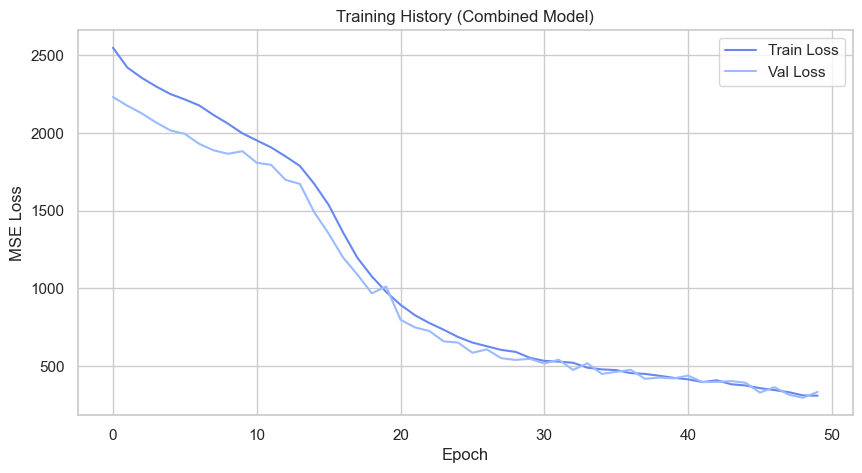

In [43]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[es],
    verbose=1
)

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('MSE Loss'); plt.title('Training History (Combined Model)')
plt.legend()
plt.show()

# Milestone 3

In [44]:
y_val_pred = model.predict(X_val).flatten()
overall_rmse = sqrt(mean_squared_error(y_val, y_val_pred))
overall_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Overall (val) RMSE: {overall_rmse:.3f} | MAE: {overall_mae:.3f}")

870/870 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
Overall (val) RMSE: 17.226 | MAE: 10.616


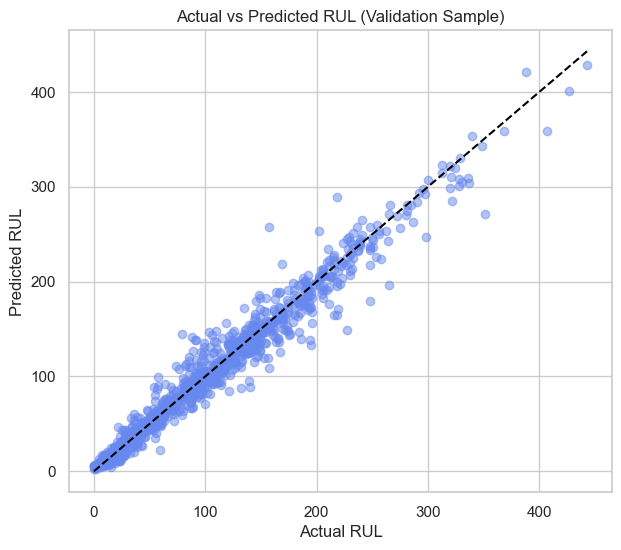

In [45]:
n_sample = min(1000, len(y_val))
plt.figure(figsize=(7,6))
plt.scatter(y_val[:n_sample], y_val_pred[:n_sample], alpha=0.5)
plt.xlabel("Actual RUL"); plt.ylabel("Predicted RUL"); plt.title("Actual vs Predicted RUL (Validation Sample)")
plt.plot([0,max(y_val[:n_sample])],[0,max(y_val[:n_sample])], color='k', linestyle='--')
plt.show()

In [46]:
x_ds_val = x_ds[idx][val_split:]  # note idx used earlier for shuffle

results = []
for d in datasets:
    mask = (x_ds_val == d)
    if mask.sum() == 0:
        continue
    y_true_d = y_val[mask]
    y_pred_d = y_val_pred[mask]
    rmse_d = sqrt(mean_squared_error(y_true_d, y_pred_d))
    mae_d = mean_absolute_error(y_true_d, y_pred_d)
    results.append((d, len(y_true_d), rmse_d, mae_d))
    
per_df = pd.DataFrame(results, columns=['dataset','n_samples','rmse','mae'])
print(per_df)

  dataset  n_samples       rmse        mae
0   FD001       3455  17.282133  10.507183
1   FD002       9287  17.305056  10.768384
2   FD003       4366  17.751411  10.636214
3   FD004      10710  16.919505  10.510678


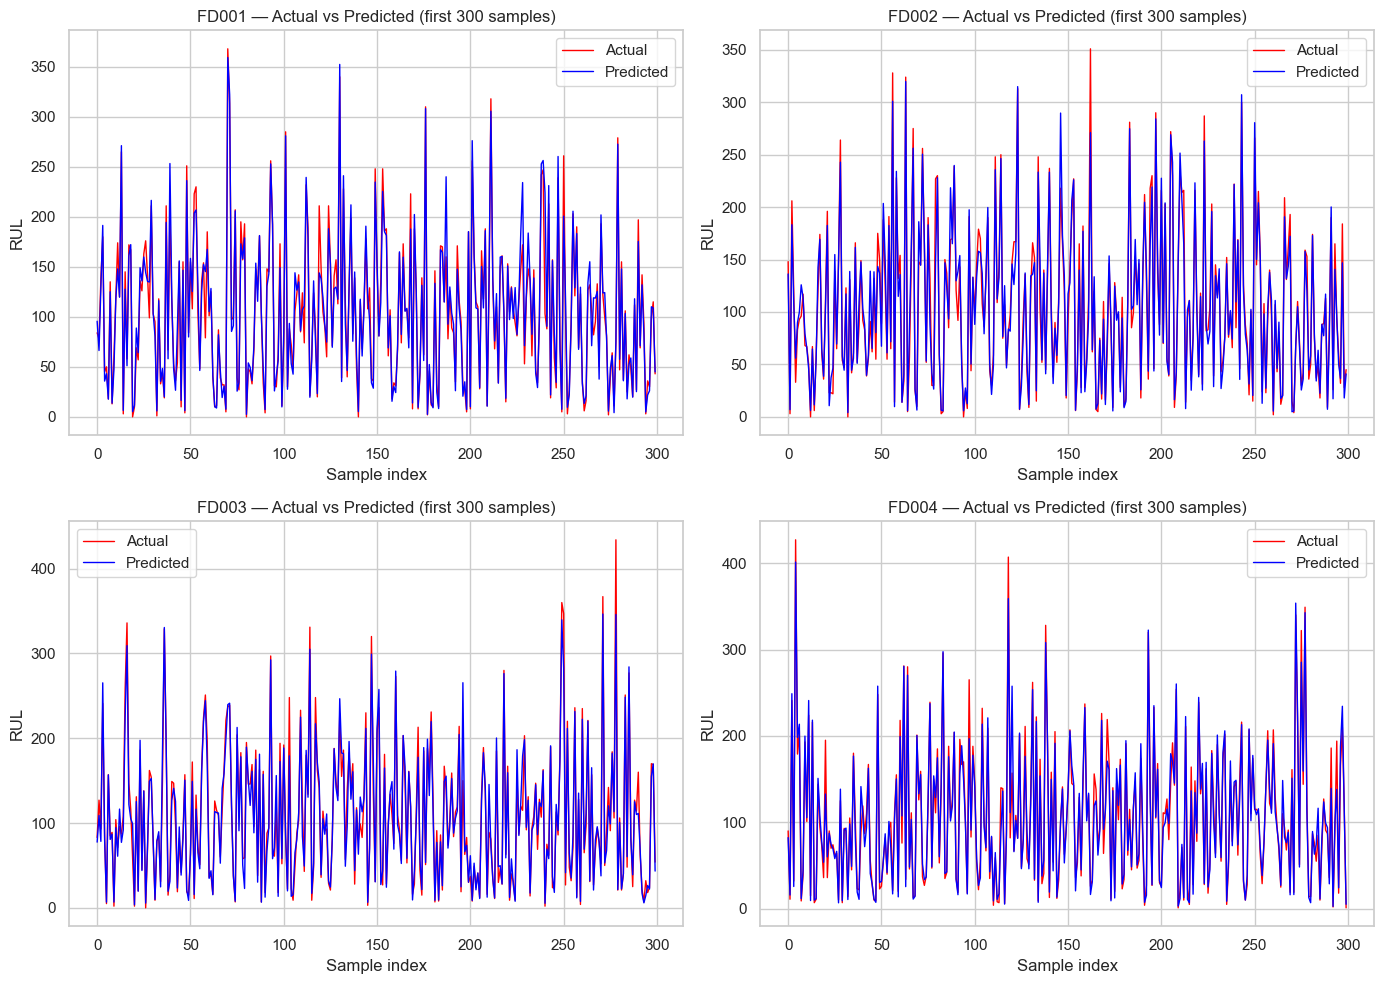

In [49]:
fig, axes = plt.subplots(2,2, figsize=(14,10))
axes = axes.flatten()
for i,d in enumerate(datasets):
    mask = (x_ds_val == d)
    if mask.sum() == 0:
        axes[i].text(0.5,0.5,f"No samples for {d}", ha='center')
        continue
    y_t = y_val[mask]
    y_p = y_val_pred[mask]
    n = min(300, len(y_t))
    axes[i].plot(y_t[:n], label='Actual', linewidth=1, color='red')
    axes[i].plot(y_p[:n], label='Predicted', linewidth=1, color='blue')
    axes[i].set_title(f"{d} — Actual vs Predicted (first {n} samples)")
    axes[i].set_xlabel("Sample index"); axes[i].set_ylabel("RUL")
    axes[i].legend()
plt.tight_layout(); plt.show()